# Characterizing and Predicting Dog Shelter Holding Lengths

## Intro
I am using data sets I obtained from Kaggle: [dog breeds parameters scraped from at dogtime.com](https://www.kaggle.com/hocop1/cat-and-dog-breeds-parameters) and the Austin Animal Center's [intake and outake records.](https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes/) . 

The Austin Animal Center data describes the animals that the shelter accepts (from various places) and the dates the animal enter and leave the shelter. The time in the shelter is an important metric: it directly affects the cost of keeping the animal, and the ideal would be to have animals adopted out in a timely manner. 

I will import several python modules, load the AAC data, and clean it. I will then load a dataset of dog breed descriptions, and replace the 'breed' features, which has hundreds of breeds listed, with the breed description variables from this second data set. This will allow the use of a very descriptive feature, without expanding it into hundreds of binary features. I will then eliminate any unhelpful features, and model the data with several machine learning models to try to estimate the time a dog will spend in the shelter.

## Setup

In [1]:
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import json
from zipfile import ZipFile
import matplotlib.pyplot as plt
import seaborn as sns
import os

#data processing 
import scipy.stats as stats
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from boruta import BorutaPy
from sklearn.base import clone
from sklearn.preprocessing import MinMaxScaler

#models
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

#model selection
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [2]:
#I will need to inspect a lot of data
pd.set_option('display.max_columns', 500)
pd.set_option('max_rows', 100)
sns.set_style("whitegrid")

## Feature Selection

### Split data
I don't want test data to influence decision on feature quality.

In [68]:
X = shelter_inout_wbreeds_df.loc[:, (shelter_inout_wbreeds_df.columns[shelter_inout_wbreeds_df.dtypes != 'object'].values)]\
    .drop(columns='time_in_shelter_days')
y = shelter_inout_wbreeds_df['time_in_shelter_days']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

### Look for multicolinearity

In [69]:
X_corr_ = X.corr().abs()
X_corr_filt = X_corr_[(X_corr_ > .75) & ~(X_corr_ == 1)]
for i, row in X_corr_filt.iterrows():
    if row.sum() > 0: 
        print("{} is correlated with: ".format(i), end = '') 
        for ind, col in row.iteritems():
            if ~np.isnan(col):
                print("{} at {}".format(ind, col))
        print("\n")

in_type_Owner Surrender is correlated with: in_type_Stray at 0.772114079068091


in_type_Stray is correlated with: in_type_Owner Surrender at 0.772114079068091


Mix is correlated with: no_breed_info2 at 0.7686794835410828


Health_Grooming is correlated with: Amount_Of_Shedding at 0.8122427683479495


Amount_Of_Shedding is correlated with: Health_Grooming at 0.8122427683479495


no_breed_info2 is correlated with: Mix at 0.7686794835410828




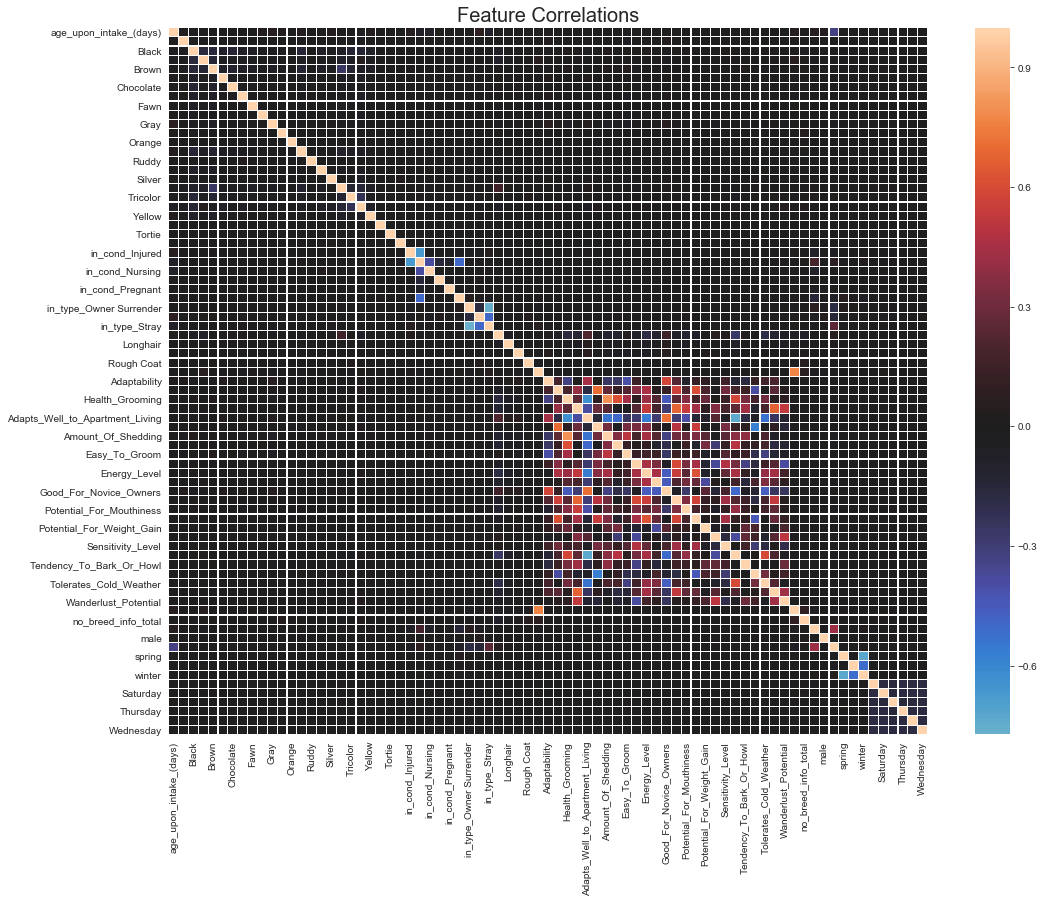

In [70]:
#look features with high correlations to multiple features
sns.set_style('darkgrid')
fig = plt.figure(figsize=(17,13))
ax = sns.heatmap(X.corr(), center=0, linewidths=.1)
ax.set_ylim(len(X.corr())-0, 0)
ax.set_title('Feature Correlations', fontsize=20);

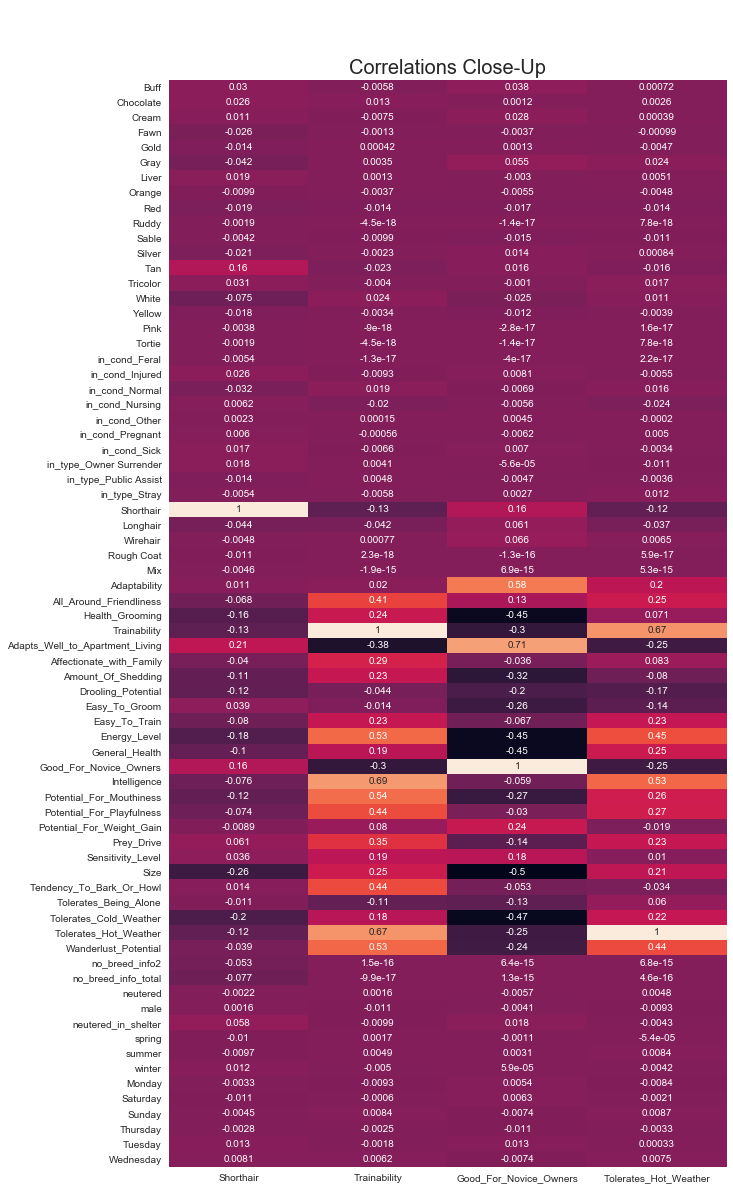

In [71]:
# Get closer look at features with potential correlation issues
plt.figure(figsize=(10, 20))
corr_closeup = X.corr().loc[:, X.corr().index.isin(['Shorthair', 'Trainability',
                                                    'Good_For_Novice_Owners',
                                                    'in_type_Owner_Surrender',
                                                    'Tolerates_Hot_Weather'])]
ax = sns.heatmap(annot=True, cbar=False,  data=corr_closeup)
ax.set_ylim(len(corr_closeup), 5)
plt.title("Correlations Close-Up", fontsize=20)

We could drop Shorthair but let's keep it until we do algorithmic feature selection.

### Look at variable distributions

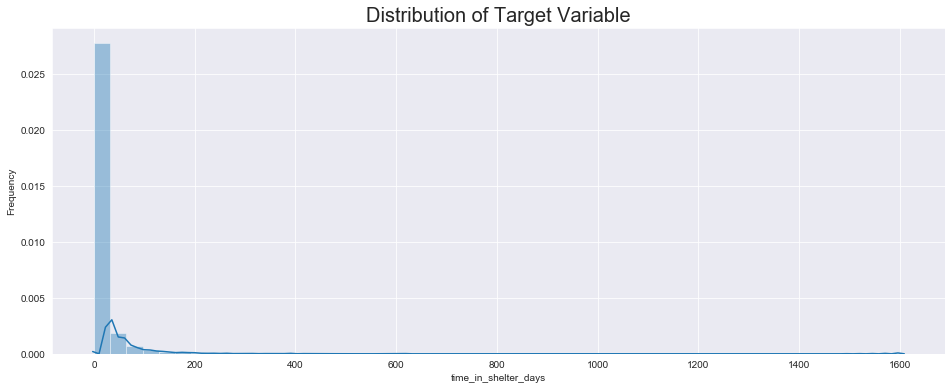

In [72]:
plt.figure(figsize=(16, 6))
ax = sns.distplot(y_train)
plt.title('Distribution of Target Variable', fontsize=20)
ax.set_ylabel('Frequency');

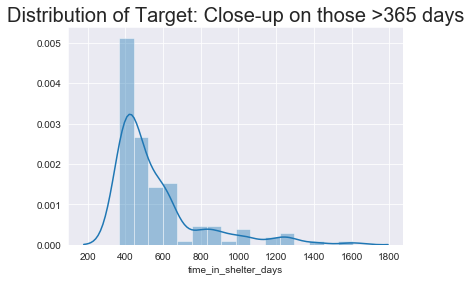

In [73]:
sns.distplot(shelter_inout_wbreeds_df.time_in_shelter_days[shelter_inout_wbreeds_df.time_in_shelter_days >365])
plt.title('Distribution of Target: Close-up on those >365 days', fontsize=20)
ax.set_ylabel('Frequency');

This is quite skewed, and apparently some dogs remain in the shelter for over 4 years! I will eliminate any observations exceeding 1 year: this is a small subset that should probably be considered separately to look at the specific issues.

In [74]:
y_drop_index = y<=365
y = y[y_drop_index]
X = X[y_drop_index]

In [75]:
#Apply boxcox transform for linear models
shift = .1
y_train_transform = pd.Series(y_train) + shift # put in series so can add to each element
y_test_transform = pd.Series(y_test) + shift
y_transform = pd.Series(y) + shift
#bc transform
y_train_transform, y_train_bc = boxcox(y_train_transform) 
y_test_transform = boxcox(y_test_transform, lmbda=y_train_bc) # use lambda from training data
y_transform = boxcox(y_transform, lmbda=y_train_bc)

In [76]:
#create function to store data used to do boxcox transform so it can be reversed later
def reverse_bc(y, lambda_used=y_train_bc):
    x = inv_boxcox(y, lmbda=lambda_used)
    x -= shift
    return x

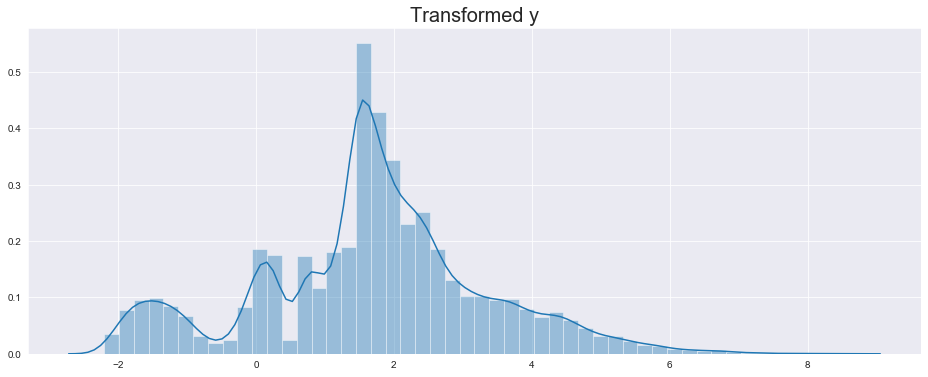

In [77]:
plt.figure(figsize=(16, 6))
sns.distplot(y_train_transform)
plt.title("Transformed y", fontsize=20);

This is not a normal distribution but much improved.

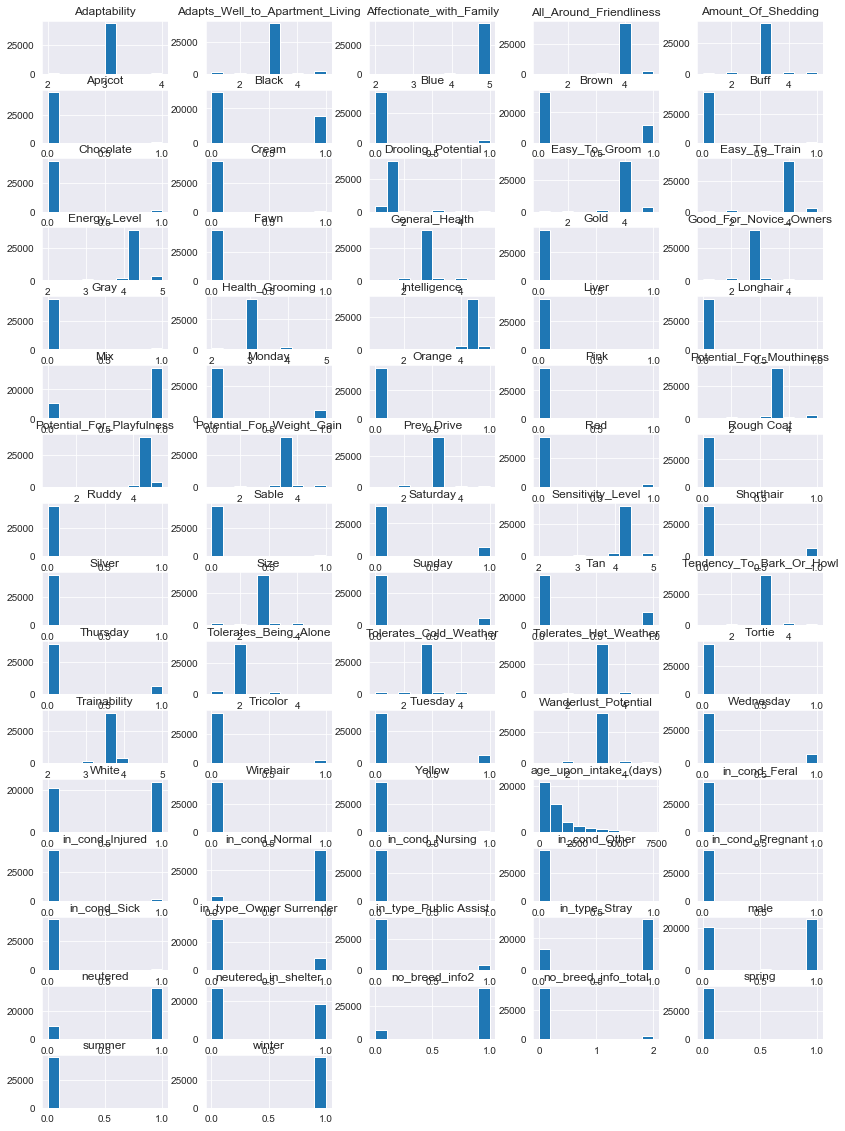

In [78]:
#Plot feature distributions
X.hist(layout=(-1,5), figsize=(14,20));    

## Algorithmic Feature Selection
To narrow down the features I will perform a Boruta feature elimination to find a set of features to test various models on; Boruta compares a randomized pseudo version of the features to real features, and selects only those features which prove beneficial to the model. I need an initial model to use as a parameter in the Boruta algorithm, and will do a random search to find a satisfactory model. 

In [ ]:
#Define search parameters and perform random search to find best params
rforest_params = {'criterion': ('mse', 'mae'),
                 'max_features': ('log2', 'sqrt', .2, .15),  
                 'max_depth': (5, 15, 30),
                 'min_samples_split': (10, 20, 30)}  

rforest = RandomForestRegressor(n_estimators=30, verbose=0, n_jobs=-1, 
                                oob_score=False, bootstrap=True)
random_forest_best = RandomizedSearchCV(estimator=rforest, n_iter=20, 
                                        n_jobs=-1, 
                                        param_distributions=rforest_params, 
                                        cv=3)
random_forest_best.fit(X_train, y_train_transform)

In [ ]:
#use hypers from search in model
random_forest_best_selector = RandomForestRegressor(**random_forest_best.best_params_).fit(X_train, y_train_transform)

In [ ]:
# use Bourta feature elimination to get alternative list of features to use
boruta_est_cnt = 30
boruta_selector_more = BorutaPy(random_forest_best_selector, n_estimators=boruta_est_cnt, verbose=0, perc=50)
boruta_selector_more.fit(X_train.values, y_train)  #Boruta only accepts np arrays

In [ ]:
boruta_selector_fewer = BorutaPy(random_forest_best_selector, n_estimators=boruta_est_cnt, verbose=0, perc=100)
boruta_selector_fewer.fit(X_train.values, y_train)  #Boruta only accepts np arrays

In [ ]:
print("Number of features Selected by Bourta Alg: More: {}, fewer: {}"\
      .format(boruta_selector_more.n_features_, boruta_selector_fewer.n_features_))
print("Selected Features (More): {}".format(X_train.columns[boruta_selector_more.support_]))
print("Selected Features (Fewer): {}".format(X_train.columns[boruta_selector_fewer.support_]))

In [ ]:
# Create new X with reducted feature set
X_train_red = X_train.loc[:,X_train.columns[boruta_selector_more.support_]]
X_test_red = X_test.loc[:,X_test.columns[boruta_selector_more.support_]]
X_red = X.loc[:,X.columns[boruta_selector_more.support_]]
X_train_red_fewer = X_train.loc[:,X_train.columns[boruta_selector_fewer.support_]]
X_test_red_fewer = X_test.loc[:,X_test.columns[boruta_selector_fewer.support_]]

In [ ]:
random_forest_best_fewer = clone(random_forest_best_selector)

In [ ]:
#compare scores for different levels of retained features
rf_cv_score_more_features = cross_val_score(estimator=random_forest_best_selector,
                                            X=X_train_red, y=y_train_transform, 
                                            cv=3, n_jobs=-1)
rf_cv_score_fewer_features = cross_val_score(estimator=random_forest_best_fewer, 
                                             X=X_train_red_fewer, y=y_train_transform, 
                                             cv=3, n_jobs=-1)
print("Score with More features retained: {}".format(rf_cv_score_more_features))
print("Score with fewer features retained: {}".format(rf_cv_score_fewer_features))

The scores are almost the same when using the highly reduced features set. However, the number of features selected is not completely stable (the runs with perc=100 have varied from 0 to 8 features selected), so I have erred on the side of caution and used the results from perc=50 as my X.

In [ ]:
#review feature importance of selected features
random_forest_best_selector.fit(X_train_red, y_train_transform)
reduced_features = X_train_red.columns.to_list()
important_features = pd.DataFrame(data=random_forest_best_selector.feature_importances_, 
                                  index=reduced_features)
important_features.columns = ['importance']
important_features.sort_values(by='importance', ascending=False,inplace=True)
figimp = plt.figure(figsize=(10,6))
aximp = sns.barplot(y=important_features.index, x=important_features['importance'], orient='h')
aximp.set(title='Ranked Featured Importance');

## Modeling

### Linear Regression
We will first try a linear regression since that has the advantage of speed, and explainability if it works well.  
We will use a random search to find the best hyperparameters.  
Models with regularization needs standardized data. Since most data is from OHE, we will use minmax.

In [ ]:
X_train_red_stand =  MinMaxScaler(feature_range=(0,1)).fit_transform(X_train_red)

In [ ]:
params = {'alpha': stats.uniform(.0001, 100),
         'l1_ratio': stats.uniform(.1, .9)}
enet = ElasticNet()
enet_rsearch = RandomizedSearchCV(estimator=enet, param_distributions=params, 
                                  n_iter=12, cv=3)
nested_lr_scores = cross_validate(estimator=enet_rsearch, X=X_train_red_stand, 
                                  y=y_train_transform, cv=3, n_jobs=-1, 
                               return_estimator=True)
print('Test scores are: {}'.format(nested_lr_scores['test_score']))

### Tree Models
There may be a number of interactions, so forest-based models may be useful to improve predictive ability.

In [ ]:
#define search space and set up model
rforest_params = {'criterion': ('mse', 'mae'),
                 'max_features': ('log2', 'sqrt', .2, .15),  
                 'max_depth': (5, 15, 30),
                 'min_samples_split': (10, 20, 30)}  

rforest = RandomForestRegressor(n_estimators=60, verbose=0, n_jobs=-1,
                                oob_score=False, bootstrap=True)
rforest_rsearch = RandomizedSearchCV(estimator=rforest,
                                     param_distributions=rforest_params,
                                     n_iter=60, cv=3)

In [ ]:
#cross validate model
rf_cv_scores = cross_validate(estimator=rforest_rsearch, X=X_train_red,
                              y=y_train_transform, n_jobs=-1, cv=3)

In [ ]:
rf_cv_scores

In [ ]:
gboost_params = {'loss': ('ls', 'lad', 'huber'),
                 'subsample': (.5, .8, 1),
                 'learning_rate': (.05, .08, .1, .2, .3, .6),
                 'max_depth': (2, 3, 5, 6)}
grad_boost = GradientBoostingRegressor(n_estimators=60)
grad_boost_rs = RandomizedSearchCV(estimator=grad_boost, param_distributions=gboost_params, cv=3)
gboost_cv_score = cross_val_score(estimator=grad_boost_rs, X=X_train_red, y=y_train_transform, n_jobs=-1, cv=3, verbose=1)

In [ ]:
gboost_cv_score

### Other Models - KNN and SVM
Since these models are still not explaining the majority of the variance, let's try some other models. We will do a similar nested CV search to get cross-validated scores of the best parameter set as determinted by the random search.

In [ ]:
kn_params = {'n_neighbors': (3, 5, 7),
             'weights': ('uniform', 'distance'),
             'p': (1.5, 2, 2.5)}
knr = KNeighborsRegressor()
knr_rsear = RandomizedSearchCV(estimator=knr, param_distributions=kn_params, n_jobs=-1, n_iter=12, cv=3)
knr_cv_score = cross_val_score(estimator=grad_boost, X=X_train_red_stand, y=y_train_transform, n_jobs=-1, cv=3, verbose=1)

In [ ]:
knr_cv_score

In [ ]:
svr_params = {'C': (.4, .7, 1, 1.3, 2, 10),
              'epsilon': (.001, .01, .1), 
              'kernel': ('linear', 'poly', 'rbf')}
svr = SVR()
svr_search = RandomizedSearchCV(estimator=svr, param_distributions=svr_params, n_jobs=-1, n_iter=12, cv=3)
svr_cv_score = cross_val_score(estimator=svr_search, X=X_train_red_stand, y=y_train_transform, n_jobs=-1, cv=3, verbose=1)

In [ ]:
svr_cv_score

### Model Score Comparison

In [ ]:
#review the cross-validated scores for the tested models
model_scores_df = pd.DataFrame(columns = ["1st", "2nd", "3rd"])
model_scores_df.loc['Linear_Regression'] = nested_lr_scores['test_score']
model_scores_df.loc['Random_Forest'] = rf_cv_scores['test_score']  
model_scores_df.loc["GradientBoost_Forest"] = gboost_cv_score
model_scores_df.loc['KNR'] = knr_cv_score
model_scores_df.loc["SVR"] = svr_cv_score
model_scores_df["mean"] = model_scores_df.mean(axis=1)
model_scores_df

I will use the gradient boosted tree model as it had somewhat better scores.

In [ ]:
#This is the model that can be used for future predictions
gboost_params = {'loss': ('ls', 'lad', 'huber'),
                 'subsample': (.5, .8, 1),
                 'learning_rate': (.05, .08, .1, .2, .3, .6),
                 'max_depth': (2, 3, 5, 6)}
grad_boost = GradientBoostingRegressor(n_estimators=60)
model = RandomizedSearchCV(estimator=grad_boost, param_distributions=gboost_params, cv=3, refit=True)
model.fit(X_train_red, y_train_transform)

In [ ]:
best_model = GradientBoostingRegressor(**model.best_params_).fit(X_train_red, y_train_transform)

In [ ]:
model.best_params_

# Interpretation  

We will use the grandient-boosted forest model. The tree models were approximately equal in cross-validation scores.  The Nearest Neighbors model was able to add some predictive information, but less than the tree-bsed models.  
The models are able to explain about 25% of the variance in the time spent in the shelter before the dogs leave. 

### Features
The model we used does not have easily interpretable coefficients. We can look more closely at the features that are most important.
It was surprising to me that some features I anticipated being important were not amoung the highest features, such as Black - this is evidence against the existance of "Black Dog Syndrome". 

In [ ]:
model_features = pd.DataFrame(data=best_model.feature_importances_, index=X_red.columns.to_list())
model_features.columns = ['importance']
model_features.sort_values(by='importance', ascending=False, inplace=True)
for feature, f_importance in model_features[0:5].iterrows():
    plt.figure(feature)
    sns.boxplot(x=X_red[feature], y=y_transform)
    plt.ylabel('transformed y')
    plt.title("{} vs time in shelter".format(feature))

None of the important variables seem too directly interpretable for on impact on the outcome variable, which makes sense given the way the models performed.

### Error Distribution

In [ ]:
#get predictions in original units and compare to actual
y_pred = inv_boxcox(model.predict(X_red), y_train_bc) 
y_pred -= shift
plt.figure(figsize=(12,10))
fig_resid = sns.scatterplot(x=y, y=y_pred, alpha=.2)
plt.plot([0, 0], [365, 365], color='r' )
plt.title("Predicted vs Actual with GBR", fontsize=20)
plt.xlabel('Actual', fontsize=15)
plt.ylabel('Predicted', fontsize=15);

## Error Distribution of SVR model
Let's see if the other models are getting a different set of observations right.

In [ ]:
knr_model = RandomizedSearchCV(estimator=knr, param_distributions=kn_params, n_jobs=-1, n_iter=12, cv=3)
knr_model.fit(X_train_red, y_train_transform)

In [ ]:
knr_model.best_estimator_

In [ ]:
y_pred_knr = inv_boxcox(knr_model.predict(X_red), y_train_bc) 
y_pred_knr -= shift
plt.figure(figsize=(12,10))
fig_resid = sns.scatterplot(x=y, y=y_pred_knr, alpha=.2)
plt.plot([0, 0], [365, 365], color='r' )
plt.title("Predicted vs Actual with KNR model", fontsize=20)
plt.xlabel('Actual', fontsize=15)
plt.ylabel('Predicted', fontsize=15);

The model is not picking up on some of the very-long staying dogs. It is capturing the cluster at around 40-75 days. 

The results of this project indicate that while the length of the stay in the shelter is influenced by some of the recorded factors, most of the variability is caused by other factors or is random. The most important factors are whether an animal is neutered while in the shelter, the age of the animal, and whether it is a stray.   

### Further Study
Additional avenues for research would include looking out the outcome categories (such as Adoption, Return to Owner, etc. ) as a predicted variable, or looking for additional variables that might influence the amount of time the animals stay in the shelter.  
It may be that important characteristics of certain dogs is not being identified in the data collected and a focus on identifying these features would be beneficial for avoiding the very long stays. 